The purpose of this notebook is to implement the K-means clustering algorithm on the provided airplanes dataset. 

In [45]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

sc = spark.sparkContext

In [46]:
SEP = ","

def remove_header(rdd):
    header = rdd.take(1)[0]
    return rdd.filter(lambda x: x != header)

In [47]:
# Get a table containing the latitude and longitude coordinates of each airport
airports_data = sc.textFile("/data/airports_data.csv")
airports_data = remove_header(airports_data)
lat_long = airports_data.map(lambda x: (x.split(SEP)[4], x.split(SEP)[3])) # Remember that latitudes and longitudes are swapped
lat_long = lat_long.map(lambda x: (float(x[0]), float(x[1])))

In [48]:
import math

"""
Using Euclidean distance for simplicity
@param coords1: (lat1, long1)
@param coords2: (lat2, long2)
@return: Euclidean distance between coords1 and coords2
"""
def distance(coords1, coords2):
    lat1 = coords1[0]
    long1 = coords1[1]
    lat2 = coords2[0]
    long2 = coords2[1]
    return math.sqrt((lat1 - lat2) ** 2 + (long1 - long2) ** 2)

In [112]:
import random
random.seed(10)

def random_clusterid(clusterids):
    return clusterids[random.randrange(len(clusterids))]

def get_mean_of_cluster(rdd, clusterid):
    """
    Gets the mean (lat, long) position of this cluster
    """
    in_cluster_only_w_id = rdd.filter(lambda x: x[2] == clusterid) # still has clusterid field
    in_cluster_only = in_cluster_only_w_id.map(lambda x: (x[0], x[1])) # does not have clusterid field
    # n_in_cluster is an int
    n_in_cluster = in_cluster_only.count()
    # sum_in_cluster is a single (lat, long tuple)
    sum_in_cluster = in_cluster_only.reduce(lambda a, b: ((a[0] + b[0]), a[1] + b[1]))
    return (sum_in_cluster[0] / n_in_cluster, sum_in_cluster[1] / n_in_cluster)

def get_cluster_means(rdd, clusterids):
    """
    Gets the means positions of all clusters
    @return: a list [(mean_lat1, mean_long1), (mean_lat2, mean_long2), ...]
    """
    return [get_mean_of_cluster(rdd, clusterid) for clusterid in clusterids]

def get_nearest_clusterid(coords, cluster_means):
    """
    Gets the clusterid with the nearest mean to a point
    @param coords: (lat, long) coordinates
    @param cluster_means: list of mean positions of all clusters, returned by get_cluster_means
    """
    cluster_mean_distances = [distance(coords, cluster_mean) for cluster_mean in cluster_means]
    return cluster_mean_distances.index(min(cluster_mean_distances))

# Implementation of k-means clustering
k = 4
n_iters = 10
clusterids = range(k)

# has tuples of the form (lat, long, clusterid), where clusterid is the id of the cluster each tuple is in
lat_long_clusterid = lat_long.map(lambda x: (x[0], x[1], random_clusterid(clusterids))) # random initialization
for i in range(n_iters):
    means = get_cluster_means(lat_long_clusterid, clusterids)
    lat_long_clusterid = lat_long_clusterid.map(lambda x: (x[0], x[1], get_nearest_clusterid((x[0], x[1]), means)))

In [113]:
# Run the below line once to install matplotlib, if it's not installed already
# !pip install --trusted-host=pypi.python.org --trusted-host=pypi.org --trusted-host=files.pythonhosted.org matplotlib

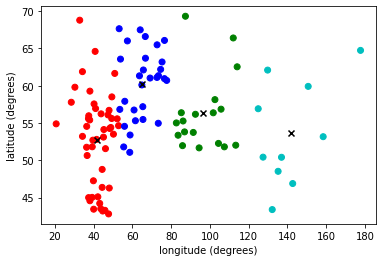

In [114]:
# Plot results
import matplotlib.pyplot as plt

# plot means
for clusterid in clusterids:
    this_mean = get_mean_of_cluster(lat_long_clusterid, clusterid)
    plt.scatter([this_mean[1]], [this_mean[0]], c="black", marker="x", zorder=1)
    
# colors
colors = ["b", "g", "r", "c", "m", "y"]
if k > len(colors):
    raise ValueError("not enough defined colors exist to color all k clusters")

lats = lat_long_clusterid.map(lambda x: x[0]).collect()
longs = lat_long_clusterid.map(lambda x: x[1]).collect()
cluster_colors = lat_long_clusterid.map(lambda x: colors[x[2]]).collect()
plt.scatter(longs, lats, c=cluster_colors, zorder=0)
plt.xlabel("longitude (degrees)")
plt.ylabel("latitude (degrees)")
plt.show()